In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [8]:
# 1. Objective Functions
def rosenbrock(params):
    x, y = params
    return (1 - x)**2 + 100 * (y - x**2)**2

def grad_rosenbrock(params):
    x, y = params
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

def sine_reciprocal(x):
    # Handling x=0 by setting f(0)=0 and adding epsilon for gradient stability
    val = x[0] if isinstance(x, np.ndarray) else x
    if abs(val) < 1e-7: return 0.0
    return np.sin(1/val)

def grad_sine_reciprocal(x):
    val = x[0] if isinstance(x, np.ndarray) else x
    if abs(val) < 1e-7: return np.array([0.0])
    return np.array([-np.cos(1/val) / (val**2)])

In [9]:
# 2. Optimizer Implementations
class ScratchOptimizers:
    def __init__(self, lr):
        self.lr = lr
        self.m = 0
        self.v = 0
        self.t = 0

    def apply(self, name, w, grad):
        self.t += 1
        if name == 'GD':
            return w - self.lr * grad
        elif name == 'SGD_Momentum':
            self.v = 0.9 * self.v + self.lr * grad
            return w - self.v
        elif name == 'Adagrad':
            self.v += grad**2
            return w - (self.lr / (np.sqrt(self.v) + 1e-8)) * grad
        elif name == 'RMSprop':
            self.v = 0.9 * self.v + 0.1 * (grad**2)
            return w - (self.lr / (np.sqrt(self.v) + 1e-8)) * grad
        elif name == 'Adam':
            self.m = 0.9 * self.m + (1 - 0.9) * grad
            self.v = 0.999 * self.v + (1 - 0.999) * (grad**2)
            m_hat = self.m / (1 - 0.9**self.t)
            v_hat = self.v / (1 - 0.999**self.t)
            return w - (self.lr * m_hat) / (np.sqrt(v_hat) + 1e-8)

In [11]:
# 3. Experiment Runner
def run_experiment(func, grad_func, start_pos, lrs, opt_names, title):
    results = {}
    fig, axes = plt.subplots(1, len(lrs), figsize=(18, 5))
    fig.suptitle(f"Convergence Behavior: {title}", fontsize=16)

    for i, lr in enumerate(lrs):
        for name in opt_names:
            opt = ScratchOptimizers(lr)
            w = np.array(start_pos, dtype=float)
            history = [func(w)]

            start_time = time.time()
            for _ in range(1500):
                g = grad_func(w)
                g = np.clip(g, -10, 10)
                w_new = opt.apply(name, w, g)
                if np.linalg.norm(w_new - w) < 1e-6: break
                w = w_new
                history.append(func(w))
            end_time = time.time()

            axes[i].plot(history, label=name)
            results[(lr, name)] = (w, history[-1], end_time - start_time)

        axes[i].set_title(f"LR = {lr}")
        axes[i].set_yscale('log')
        axes[i].set_xlabel("Iterations")
        axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return results

Running Rosenbrock Optimization...


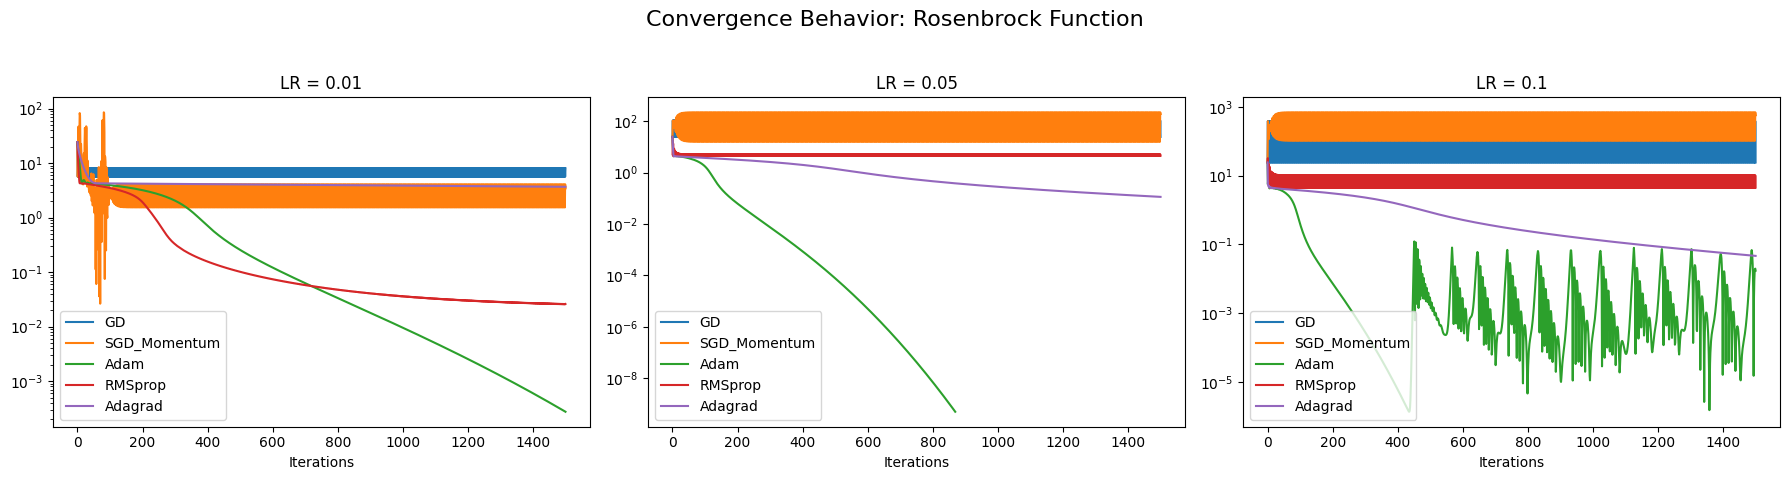


Running Sine Reciprocal Optimization...


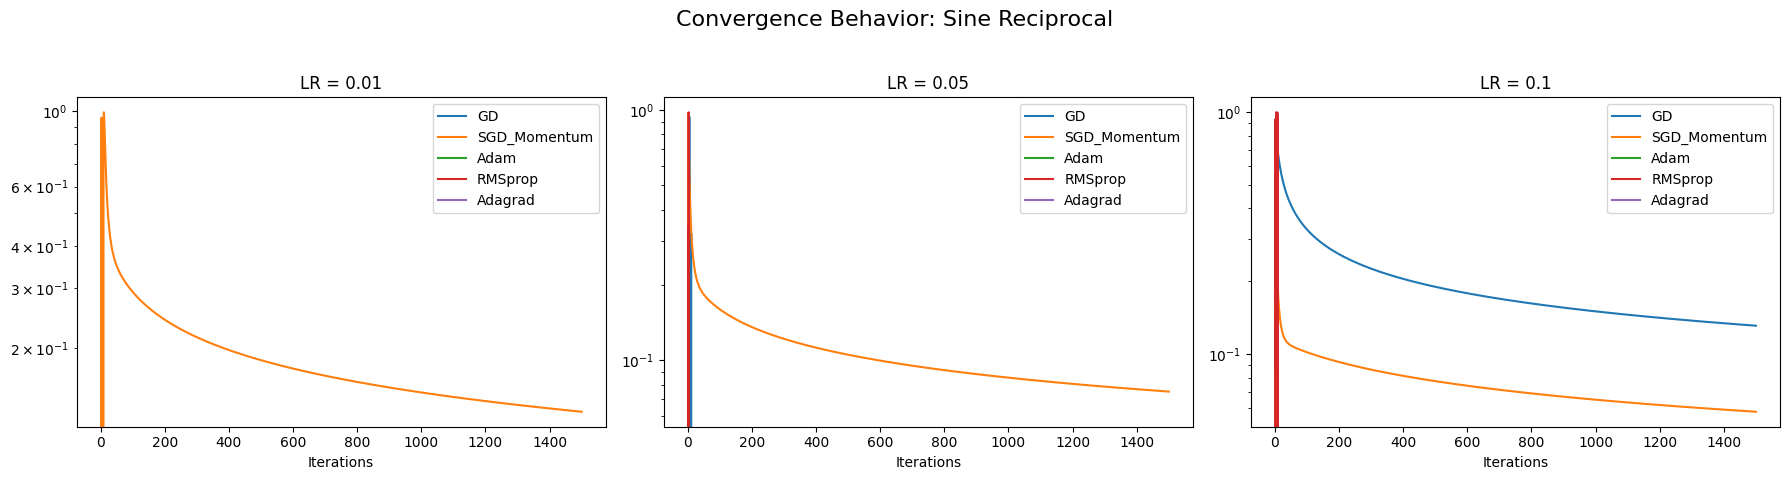

In [12]:
# 4. Main Execution
learning_rates = [0.01, 0.05, 0.1]
optimizers = ['GD', 'SGD_Momentum', 'Adam', 'RMSprop', 'Adagrad']

print("Running Rosenbrock Optimization...")
rosen_res = run_experiment(rosenbrock, grad_rosenbrock, [-1.2, 1.0], learning_rates, optimizers, "Rosenbrock Function")

print("\nRunning Sine Reciprocal Optimization...")
# Starting at x=0.2 to see if it moves towards the complex origin
sine_res = run_experiment(sine_reciprocal, grad_sine_reciprocal, [0.2], learning_rates, optimizers, "Sine Reciprocal")

In [13]:
# 5. Data Presentation
print("\n" + "="*80)
print(f"{'LR':<6} | {'Optimizer':<15} | {'Optimal x/y':<20} | {'f(x)':<10} | {'Time(s)':<8}")
print("-"*80)
for (lr, name), (pos, val, t) in rosen_res.items():
    pos_str = np.array2string(pos, precision=3)
    print(f"{lr:<6} | {name:<15} | {pos_str:<20} | {val:<10.4e} | {t:<8.4f}")


LR     | Optimizer       | Optimal x/y          | f(x)       | Time(s) 
--------------------------------------------------------------------------------
0.01   | GD              | [-1.   1.2]          | 8.0000e+00 | 0.0628  
0.01   | SGD_Momentum    | [1.003 1.192]        | 3.4366e+00 | 0.0344  
0.01   | Adam            | [0.983 0.967]        | 2.7520e-04 | 0.0480  
0.01   | RMSprop         | [0.921 0.862]        | 2.6011e-02 | 0.0581  
0.01   | Adagrad         | [-0.914  0.843]      | 3.6688e+00 | 0.0339  
0.05   | GD              | [-1.2  1. ]          | 2.4200e+01 | 0.0353  
0.05   | SGD_Momentum    | [-1.449  0.751]      | 1.8747e+02 | 0.0444  
0.05   | Adam            | [1. 1.]              | 5.0831e-10 | 0.0277  
0.05   | RMSprop         | [-1.06   1.074]      | 4.4953e+00 | 0.0372  
0.05   | Adagrad         | [0.664 0.44 ]        | 1.1304e-01 | 0.0352  
0.1    | GD              | [-1.2  1. ]          | 2.4200e+01 | 0.0266  
0.1    | SGD_Momentum    | [-1.697  0.503]      | 5.72